# SI 699: Project Phase 1

Proof of concept through replication and test data search+EDA

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import spacy
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import ttest_ind
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, accuracy_score

### Data setup

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Fall 25 (Second Year MSI)/SI 611: Mastery Course/hcV3-stories.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6854 entries, 0 to 6853
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       6854 non-null   object 
 1   WorkTimeInSeconds  6854 non-null   int64  
 2   WorkerId           6854 non-null   object 
 3   annotatorAge       6831 non-null   float64
 4   annotatorGender    6854 non-null   object 
 5   annotatorRace      6854 non-null   object 
 6   distracted         6854 non-null   float64
 7   draining           6854 non-null   float64
 8   frequency          4098 non-null   float64
 9   importance         6710 non-null   float64
 10  logTimeSinceEvent  6854 non-null   float64
 11  mainEvent          6854 non-null   object 
 12  memType            6854 non-null   object 
 13  mostSurprising     6854 non-null   object 
 14  openness           6854 non-null   float64
 15  recAgnPairId       2619 non-null   object 
 16  recImgPairId       5328 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
WorkTimeInSeconds,6854.0,2.094556e+03,1.694784e+03,173.00000,924.250000,1526.00000,2678.500000,1.068000e+04
annotatorAge,6831.0,3.355351e+01,1.014654e+01,18.00000,25.000000,30.00000,40.000000,5.500000e+01
distracted,6854.0,1.416837e+00,8.908060e-01,1.00000,1.000000,1.00000,1.000000,5.000000e+00
draining,6854.0,2.182521e+00,1.310124e+00,1.00000,1.000000,2.00000,3.000000,5.000000e+00
frequency,4098.0,3.646413e+00,1.028357e+00,1.00000,3.000000,4.00000,4.000000,5.000000e+00
importance,6710.0,3.952608e+00,1.258208e+00,1.00000,3.000000,4.00000,5.000000,5.000000e+00
logTimeSinceEvent,6854.0,7.001817e+00,1.320011e+01,1.94591,3.555348,4.49981,5.010635,1.368181e+02
openness,6854.0,5.593996e-01,4.164938e-01,-1.00000,0.250000,0.62500,0.875000,1.000000e+00
similarity,2756.0,2.916546e+00,1.441768e+00,1.00000,2.000000,3.00000,4.000000,5.000000e+00
stressful,6854.0,2.168223e+00,1.325316e+00,1.00000,1.000000,2.00000,3.000000,5.000000e+00


In [ ]:
df.shape

(6854, 23)

In [ ]:
df.size

157642

In [ ]:
df.isna().mean().sort_values(ascending=False)

,0
recAgnPairId,0.617887
similarity,0.597899
similarityReason,0.597899
frequency,0.402101
recImgPairId,0.222644
importance,0.021010
annotatorAge,0.003356
distracted,0.000000
annotatorRace,0.000000
annotatorGender,0.000000


### Replication

i.e. testing that language features can distinguish imagination vs memory - Using only Recalled and imgained stories for now


In [ ]:
# filter dataset
df = df[df["memType"].isin(["imagined", "recalled"])].copy()
df.shape

(5535, 23)

In [ ]:
# clean up the text

df["story_clean"] = df["story"].str.lower().str.replace(r"[^a-z\s]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df["tokens"] = df["story_clean"].str.split()

# token stats
df["n_tokens"] = df["tokens"].apply(len)
df["n_chars"] = df["story_clean"].str.len()

df[["memType","n_tokens","n_chars"]].describe().T

,count,mean,std,min,25%,50%,75%,max
n_tokens,5535.0,260.191509,88.995418,110.0,198.0,246.0,309.0,611.0
n_chars,5535.0,1306.335501,458.384249,569.0,980.0,1236.0,1562.5,2959.0


In [ ]:
# feature engineering and extraction

# first define word categories that may be helpful eg modal verbs
MODALS = {
    "might","could","maybe","possibly","perhaps","seems","seemed","appear","appears","appeared",
    "guess","guessing","likely","unlikely","probably","apparently","supposedly","presumably",
    "as","like","as if"
}

# define first vs third person lists
FIRST_PERSON = {"i","me","my","mine","myself"}
THIRD_PERSON = {"he","him","his","she","her","hers","they","them","their","theirs"}

In [ ]:
# create modal realted features
df["modal"] = df["tokens"].apply(lambda x: len([w for w in x if w in MODALS]))
df["modal_rate"] = df["tokens"].apply(lambda x: sum(w in MODALS for w in x) / len(x) if len(x) > 0 else 0)

# get length feature
df["story_length"] = df["tokens"].apply(len)
df["summary_length"] = df["summary"].str.split().apply(len)

# first person pronoun rate (for more personal story telling style)
df["first_person_rate"] = df["tokens"].apply(lambda x: sum(w in FIRST_PERSON for w in x) / len(x) if len(x) > 0 else 0)

# third person pronoun rate (for detached storytelling style)
df["third_person_rate"] = df["tokens"].apply(lambda x: sum(w in THIRD_PERSON for w in x) / len(x) if len(x) > 0 else 0)

# sentiment feature
df["sentiment"] = df["story"].apply(lambda x: TextBlob(x).sentiment.polarity)

# subjectivity feature: 0 = factual/objective, 1 = highly personal/opinionated (imagined or hallucinated texts are often more subjective)
df["subjectivity"] = df["story"].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [ ]:
features = df[["memType","modal","modal_rate","story_length","summary_length","first_person_rate","third_person_rate","sentiment","subjectivity"]]

summary = features.groupby("memType").agg(["mean","std","median","count"])
summary

modal                        modal_rate                      \
              mean       std median count       mean       std    median   
memType                                                                    
imagined  3.179245  2.636162    3.0  2756   0.012618  0.009612  0.011385   
recalled  3.242893  2.679754    3.0  2779   0.011343  0.008207  0.010381   

               story_length             ... third_person_rate       sentiment  \
         count         mean        std  ...            median count      mean   
memType                                 ...                                     
imagined  2756   243.805152  86.296388  ...          0.026316  2756  0.152592   
recalled  2779   276.442245  88.666051  ...          0.025281  2779  0.141791   

                                   subjectivity                            
               std    median count         mean       std    median count  
memType                                                                    
imagined  0.135096  0.154031  2756     0.510085  0.085520  0.507928  2756  
recalled  0.127810  0.139827  2779     0.497235  0.084817  0.495664  2779  

[2 rows x 32 columns]

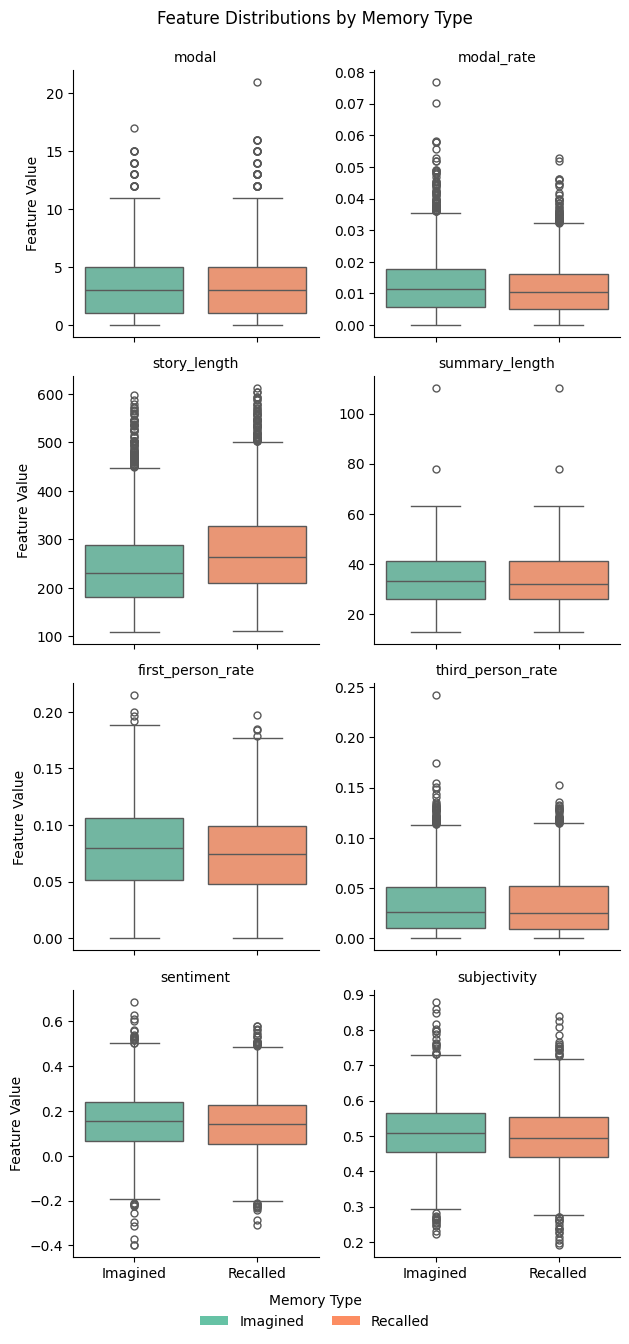

In [ ]:
# fix data
plot_cols = [c for c in features.columns if c != "memType"]
melted = features.melt(
    id_vars="memType", value_vars=plot_cols,
    var_name="Feature", value_name="Value"
)
melted["Memory Type"] = melted["memType"].map(
    {"imagined": "Imagined", "recalled": "Recalled"}
)

# plot
g = sns.catplot(
    data=melted,
    x="Memory Type", y="Value", hue="Memory Type",
    col="Feature", kind="box",
    sharey=False, col_wrap=2,
    palette="Set2", height=3.2,
    legend=False
)
g.set_titles("{col_name}")
g.set_axis_labels("", "Feature Value")
g.fig.suptitle("Feature Distributions by Memory Type", y=1.02)

palette = sns.color_palette("Set2", 2)
handles = [
    Patch(facecolor=palette[0], label="Imagined"),
    Patch(facecolor=palette[1], label="Recalled"),
]
g.figure.legend(
    handles=handles, title="Memory Type",
    loc="lower center", bbox_to_anchor=(0.5, -0.02),
    frameon=False, ncol=2
)

plt.show()


In [ ]:
# ttests

# numeric cols
feature_cols = (features.select_dtypes(include="number").columns.tolist())

def t_test_between_groups(feat):
    a = pd.to_numeric(features.loc[features["memType"]=="recalled", feat],
                      errors="coerce").dropna()
    b = pd.to_numeric(features.loc[features["memType"]=="imagined", feat],
                      errors="coerce").dropna()
    if len(a) < 3 or len(b) < 3:
        return {"feature": feat, "note": "Not enough data for t-test",
                "pval": np.nan, "stat": np.nan,
                "recalled_mean": a.mean() if len(a) else np.nan,
                "imagined_mean": b.mean() if len(b) else np.nan}
    stat, p = ttest_ind(a, b, equal_var=False)
    return {"feature": feat, "stat": stat, "pval": p,
            "recalled_mean": a.mean(), "imagined_mean": b.mean()}

tests = pd.DataFrame([t_test_between_groups(f) for f in feature_cols])
tests


,feature,stat,pval,recalled_mean,imagined_mean
0,modal,0.890760,3.730965e-01,3.242893,3.179245
1,modal_rate,-5.304992,1.171828e-07,0.011343,0.012618
2,story_length,13.877343,4.550017e-43,276.442245,243.805152
3,summary_length,-0.320798,7.483756e-01,34.158690,34.247823
4,first_person_rate,-5.294171,1.242056e-07,0.074179,0.079388
5,third_person_rate,-0.648287,5.168262e-01,0.033506,0.034015
6,sentiment,-3.054953,2.261717e-03,0.141791,0.152592
7,subjectivity,-5.612192,2.094912e-08,0.497235,0.510085


#### Classification model

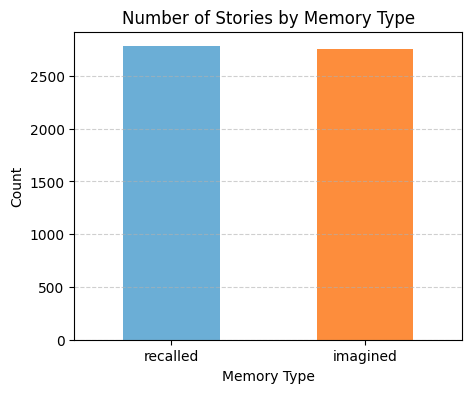

In [ ]:
# quick dist plot to see if dataset is balanced:

mem_counts = features["memType"].value_counts()

plt.figure(figsize=(5,4))
mem_counts.plot(kind="bar", color=["#6BAED6", "#FD8D3C"])
plt.title("Number of Stories by Memory Type")
plt.xlabel("Memory Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()



Test accuracy: 0.593
Test ROC-AUC : 0.632

Classification report (0=recalled, 1=imagined):

              precision    recall  f1-score   support

           0      0.577     0.605     0.591       806
           1      0.610     0.581     0.595       855

    accuracy                          0.593      1661
   macro avg      0.593     0.593     0.593      1661
weighted avg      0.594     0.593     0.593      1661


Confusion matrix:

                 recalled (pred)  imagined (pred)
recalled (true)              488              318
imagined (true)              358              497


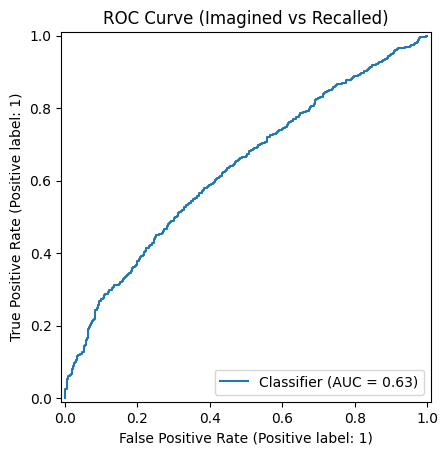


Logistic regression coefficients (positive ⇒ predicts 'imagined'):
          feature      coef
            modal  0.221563
     subjectivity  0.098566
   summary_length  0.095504
first_person_rate  0.089964
        sentiment  0.029597
third_person_rate  0.028493
       modal_rate  0.019224
     story_length -0.481408


In [ ]:
# logistic regression

# select features (use only columns that exist)
use_feats = features.columns.tolist()
use_feats.remove("memType")

# set up
X = features[use_feats].copy()
# map label: imagined = 1, recalled = 0
y = (features["memType"].astype(str).str.lower() == "imagined").astype(int)
t
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# fit and pred
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("\nTest accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Test ROC-AUC :", round(roc_auc_score(y_test, y_proba), 3))
print("\nClassification report (0=recalled, 1=imagined):\n")
print(classification_report(y_test, y_pred, digits=3))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
cm_df = pd.DataFrame(cm, index=["recalled (true)","imagined (true)"],
                         columns=["recalled (pred)","imagined (pred)"])
print("\nConfusion matrix:\n")
print(cm_df)

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve (Imagined vs Recalled)")
plt.show()

# coeffs
lr = pipe.named_steps["clf"]
scaler = pipe.named_steps["scaler"]

coef = lr.coef_.ravel()
coef_df = pd.DataFrame({
    "feature": use_feats,
    "coef": coef
}).sort_values("coef", ascending=False)

print("\nLogistic regression coefficients (positive ⇒ predicts 'imagined'):")
print(coef_df.to_string(index=False))


In [ ]:
# gradient boosting

from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, scale_pos_weight=1
)
xgb.fit(X_train, y_train)
roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])


np.float64(0.6304040201937604)

Accuracy: 0.606
ROC-AUC : 0.645

Classification report:
               precision    recall  f1-score   support

           0      0.599     0.649     0.623       834
           1      0.613     0.562     0.587       827

    accuracy                          0.606      1661
   macro avg      0.606     0.605     0.605      1661
weighted avg      0.606     0.606     0.605      1661


Confusion Matrix:
 [[541 293]
 [362 465]]


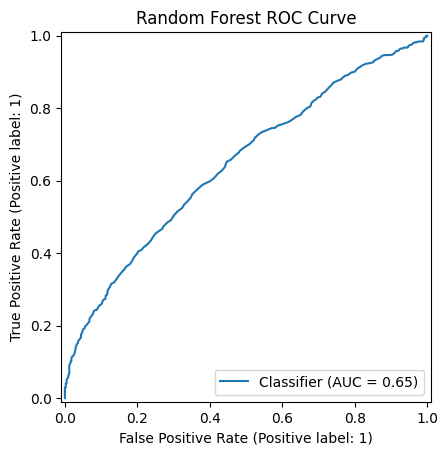


Feature importances:
story_length         0.172
first_person_rate    0.151
subjectivity         0.148
sentiment            0.144
modal_rate           0.134
third_person_rate    0.132
summary_length       0.120
dtype: float64


In [ ]:
# random forest

# setup

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced",  # handles small imbalance if present
    n_jobs=-1
)

# fit and preds
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# get and show metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC-AUC :", round(roc_auc_score(y_test, y_proba), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Random Forest ROC Curve")
plt.show()

# feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(importances.round(3))


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 600}
Best CV ROC-AUC: 0.6428917532112919


In [ ]:
best_rf = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=600,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=600, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred, digits=3))


Test Accuracy: 0.605
Test ROC-AUC: 0.656
              precision    recall  f1-score   support

           0      0.598     0.651     0.623       834
           1      0.614     0.559     0.585       827

    accuracy                          0.605      1661
   macro avg      0.606     0.605     0.604      1661
weighted avg      0.606     0.605     0.604      1661



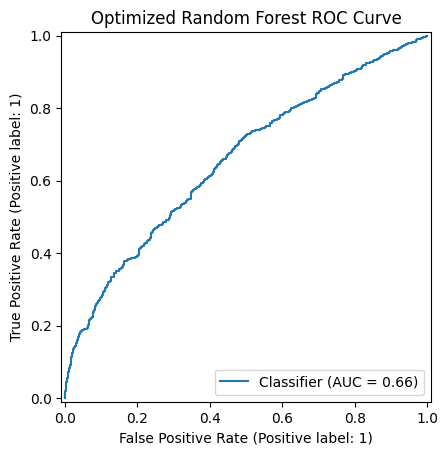

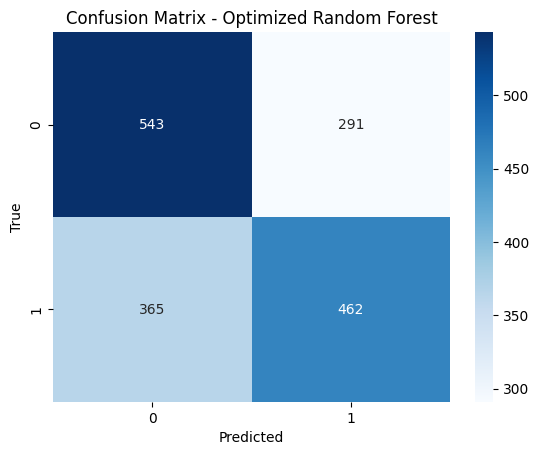

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Optimized Random Forest ROC Curve")
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Optimized Random Forest')
plt.show()
